In [1]:
import torch
import torch.nn as nn
import random
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


print('Selected available:', device)

Selected available: cuda


In [2]:
import json
from collections import OrderedDict
from utils.Vocabulary import Vocabulary

min_freq = 75
eng_vocab_file = "../data-sets/vocab_eng.json"
nld_vocab_file = "../data-sets/vocab_nld.json"

with open(eng_vocab_file, mode="r") as f:
    eng_dict = json.load(f, object_pairs_hook=OrderedDict)

with open(nld_vocab_file, mode="r") as f:
    nld_dict = json.load(f, object_pairs_hook=OrderedDict)

eng_vocab = Vocabulary(eng_dict, min_freq=min_freq)
nld_vocab = Vocabulary(nld_dict, min_freq=min_freq)

print("English vocabulary:", eng_vocab)
print("Dutch vocabulary:", nld_vocab)

print()
print("Index of token \"The\":", eng_vocab.token_to_index["the"])
print("Token on index 24:", eng_vocab.index_to_token[24])

English vocabulary: Vocabulary with 58713 tokens.
Dutch vocabulary: Vocabulary with 92497 tokens.

Index of token "The": 7
Token on index 24: be


In [3]:
''' Hyperparameters: '''

# Model parameters
emb_dim       = 100
hidden_size   = 300 # The same hidden size for encoder and decoder
num_layers    =   3
dropout       =   0

# Training parameters
batch_size    = 256
epochs        = 3
learning_rate = 0.0001 # If you double the bs, you might double the lr
weight_decay  = 0.00005 # Penalize complexity by couting weights into the loss function

In [4]:
from utils.CustomDataSet import CustomDataSet
from torch.utils.data import DataLoader, random_split

train_split = 0.9
file = "../data-sets/filtered_and_tokenized_sentences(1).csv"

dataset = CustomDataSet(file, output_size=20, input_vocab=eng_vocab, target_vocab=nld_vocab)

''' Calculate split sizes '''
dataset_size = len(dataset)
train_size = int(train_split * dataset_size)
test_size = dataset_size - train_size

''' Split the dataset up '''
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

''' Create Data Loaders '''
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)



print("Train data:", train_size)
print("Test data:", test_size)

Train data: 4500000
Test data: 500000


In [5]:
from RNN.Seq2Seq import Seq2Seq

''' Construct the model '''
model = Seq2Seq(
    len(eng_vocab),
    len(nld_vocab),
    emb_dim,
    hidden_size,
    hidden_size,
    num_layers,
    dropout,
).to(device)



''' Display where all the model's parameters are exactly located '''
def count_params(module, indent=0, module_name=""):
    total_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

    name_str = f"{module_name} ({module.__class__.__name__})" if module_name else module.__class__.__name__
    print(f'{"  " * indent}- {name_str}: {total_params:,d}')

    for name, submodule in module.named_children():
        count_params(submodule, indent + 1, name)

count_params(model)

- Seq2Seq: 49,399,697
  - encoder (Encoder): 9,842,100
    - embeddings (Embedding): 5,871,300
    - rnn (GRU): 3,970,800
    - dropout (Dropout): 0
  - decoder (Decoder): 39,377,297
    - embeddings (Embedding): 9,249,700
    - attention (Attention): 450,300
      - W1 (Linear): 270,000
      - W2 (Linear): 180,000
      - V (Linear): 300
    - input_fc (Linear): 210,300
    - rnn (GRU): 1,625,400
    - fc (Linear): 27,841,597
    - dropout (Dropout): 0
  - fc_hidden (Linear): 180,300


In [6]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html



criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [8]:
'''
Helper functions for the training loop
'''

''' Calculate a teaching ratio, gradually decreasing during the first epoch '''
def forced_teaching_ratio(current_epoch, current_step, total_steps):
    if current_epoch > 0:
        return 0
    else:
        progress = current_step / total_steps
        return 1 - progress

''' Calculate loss on train and test data '''
@torch.inference_mode()
def log_statistics(eval_batch_size=64):

    # Create a completely empty 'target' for the model
    empty_target = torch.zeros((eval_batch_size, 20), dtype=torch.long).to(device)
    empty_target[:, 0] = 1 # <SOS> has index of 1

    model.eval()

    # Train dataset evaluation
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device, dtype=torch.long), targets.to(device, dtype=torch.long)

    outputs = model(inputs, empty_target)
    train_loss = criterion(outputs, targets)


    # Test dataset evaluation
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device, dtype=torch.long), targets.to(device, dtype=torch.long)

    outputs = model(inputs, empty_target)
    test_loss = criterion(outputs, targets)

    return train_loss.item(), test_loss.item()

def compute_l2_weights(model):
    total_l2_norm = 0
    for param in model.parameters():
        if param.requires_grad:  # Ensure we only compute L2 norm for weights that require gradients
            total_l2_norm += torch.norm(param, p=2).item()  # Compute the L2 norm (p=2)
    return total_l2_norm

def compute_weight_stats(model):
    total_sum = 0
    total_sum_sq = 0
    param_count = 0

    for param in model.parameters():
        if param.requires_grad:
            param_data = param.data.view(-1)  # Flatten the tensor to 1D
            total_sum += param_data.sum().item()
            total_sum_sq += (param_data ** 2).sum().item()
            param_count += param.numel()

    if param_count == 0:
        return 0, 0

    # Compute the mean
    mean = total_sum / param_count

    # Compute the variance and standard deviation
    variance = (total_sum_sq / param_count) - (mean ** 2)
    std_dev = variance ** 0.5

    return mean, std_dev

def compute_gradient_norm_per_module(model):
    gradient_norms = {}

    # Iterate over each submodule in the model
    for name, module in model.named_modules():
        total_norm = 0
        grad_count = 0

        # Calculate gradient norm for this specific submodule
        for param in module.parameters(recurse=False):  # Only parameters directly in this module
            if param.grad is not None:
                total_norm += param.grad.data.norm(2).item()
                grad_count += param.numel()

        # Store the gradient norm for this submodule
        if grad_count > 0:
            gradient_norms[name] = total_norm / grad_count

    return gradient_norms

In [15]:
from tqdm.notebook import tqdm

reference_iter      = []
train_loss_values   = []
test_loss_values    = []
l2_norms            = []
weight_means        = []
weight_stds         = []
submodule_gradients = {}  # Dictionary to store gradients for each submodule

global_iteration = 0
batch_count = len(train_loader)
total_iterations = epochs * batch_count

# Initialize submodule gradient lists for each submodule
for name, _ in model.named_modules():
    submodule_gradients[name] = []

for epoch in tqdm(range(epochs), desc="Epochs"):

    for i, (inputs, targets) in tqdm(enumerate(train_loader), total=batch_count, desc="Batches", leave=False):
        model.train()
        global_iteration += 1
        ft_ratio = forced_teaching_ratio(epoch, i, batch_count)

        ''' Sample mini-batch and send to gpu '''
        inputs, targets = inputs.to(device, dtype=torch.long), targets.to(device, dtype=torch.long)

        ''' Perform a single training iteration '''
        output = model(inputs, targets, ft_ratio) # Do the forward pass
        loss = criterion(output, targets)         # Calculate the loss
        optimizer.zero_grad()                     # Reset parameters
        loss.backward()                           # Backpropagation
        optimizer.step()                          # Update parameters

        ''' Report progression every so often '''
        if ((global_iteration + 1) % (total_iterations // 50) == 0 or global_iteration == total_iterations):
            train_loss, test_loss = log_statistics(batch_size)

            reference_iter.append(global_iteration)
            train_loss_values.append(train_loss)
            test_loss_values.append(test_loss)

            l2_norms.append(compute_l2_weights(model))

            ''' Compute mean and std dev of weights '''
            mean_weight, std_weight = compute_weight_stats(model)
            weight_means.append(mean_weight)
            weight_stds.append(std_weight)

            ''' Collect gradient norms per submodule '''
            grad_norms = compute_gradient_norm_per_module(model)
            for name, grad_norm in grad_norms.items():
                submodule_gradients[name].append(grad_norm)


        if (global_iteration == total_iterations):
            # Print final results
            print()
            print('Final training loss:', round(train_loss, 3))
            print('Final test loss:    ', round(test_loss, 3))

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/17579 [00:00<?, ?it/s]

Batches:   0%|          | 0/17579 [00:00<?, ?it/s]

Batches:   0%|          | 0/17579 [00:00<?, ?it/s]


Final training loss: 3.326
Final test loss:     3.061


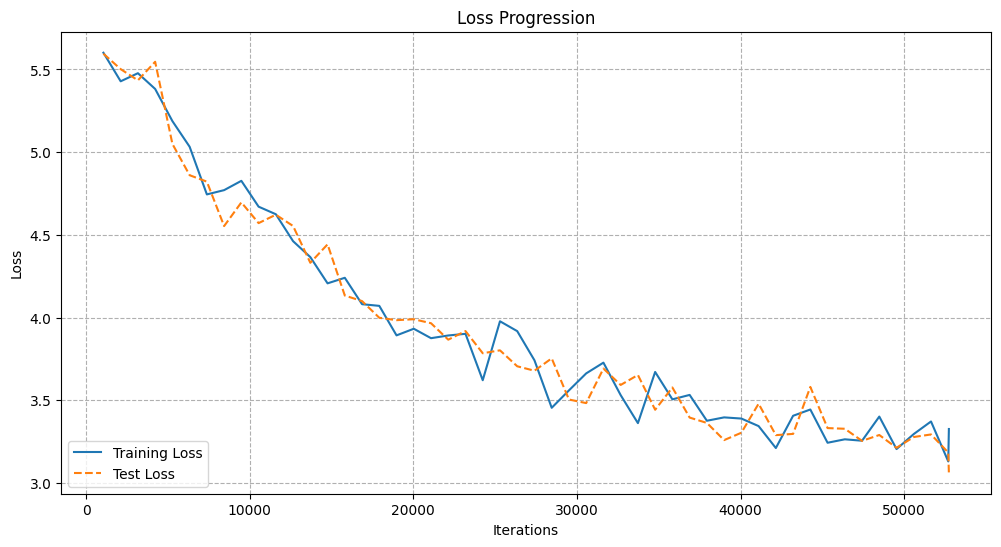

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
plt.grid(ls='--')

ax1.plot(reference_iter, train_loss_values, label='Training Loss')
ax1.plot(reference_iter, test_loss_values, label='Test Loss', linestyle='--')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Progression')

ax1.legend(loc='lower left')
plt.show()

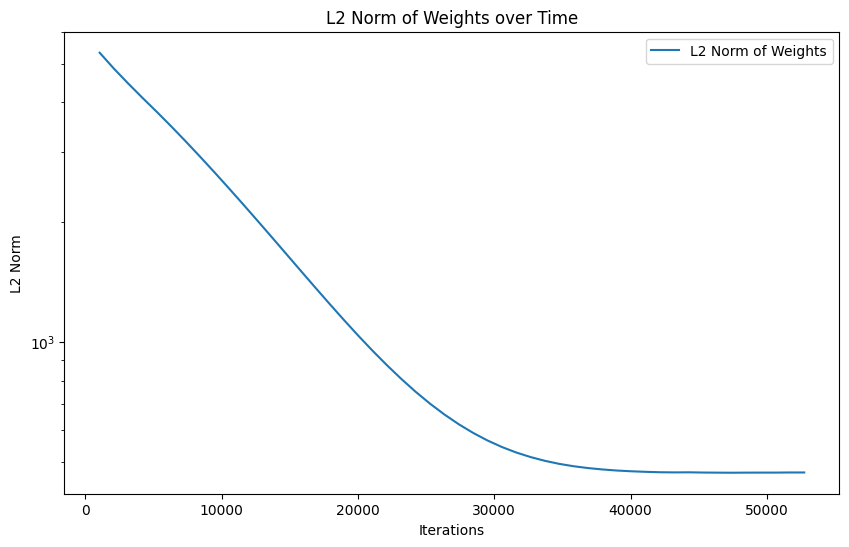

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(reference_iter, l2_norms, label="L2 Norm of Weights")
plt.xlabel("Iterations")
plt.ylabel("L2 Norm")
plt.title("L2 Norm of Weights over Time")

plt.yscale('log')

plt.legend()
plt.show()

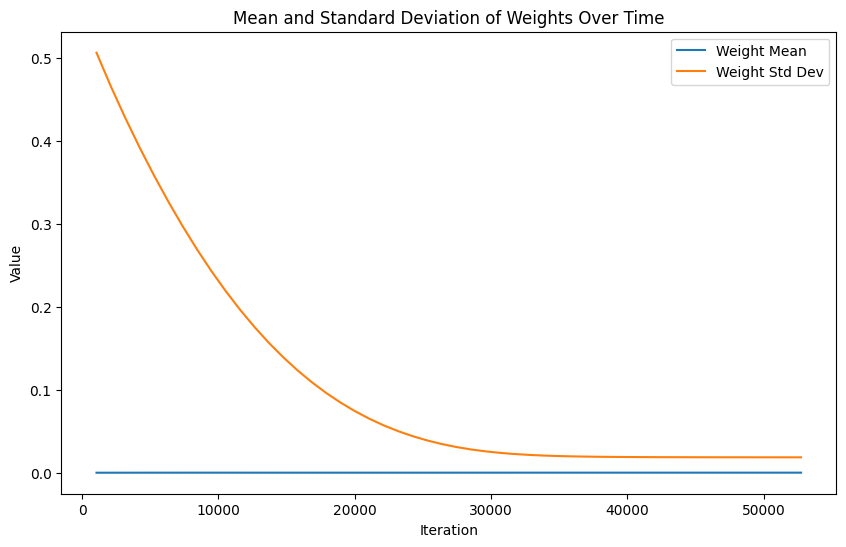

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(reference_iter, weight_means, label='Weight Mean')
plt.plot(reference_iter, weight_stds, label='Weight Std Dev')

plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Mean and Standard Deviation of Weights Over Time")

plt.legend()
plt.show()


A gradual decrease typically indicates the effect of weight decay, which penalizes large weights and encourages the model to prefer smaller weights. This reduces overfitting.

Excessive decrease might suggest that the weight decay is too strong, causing weights to become too small. The model is restricted to capture complex data.

Large weight norms or fluctuations are undesirable.

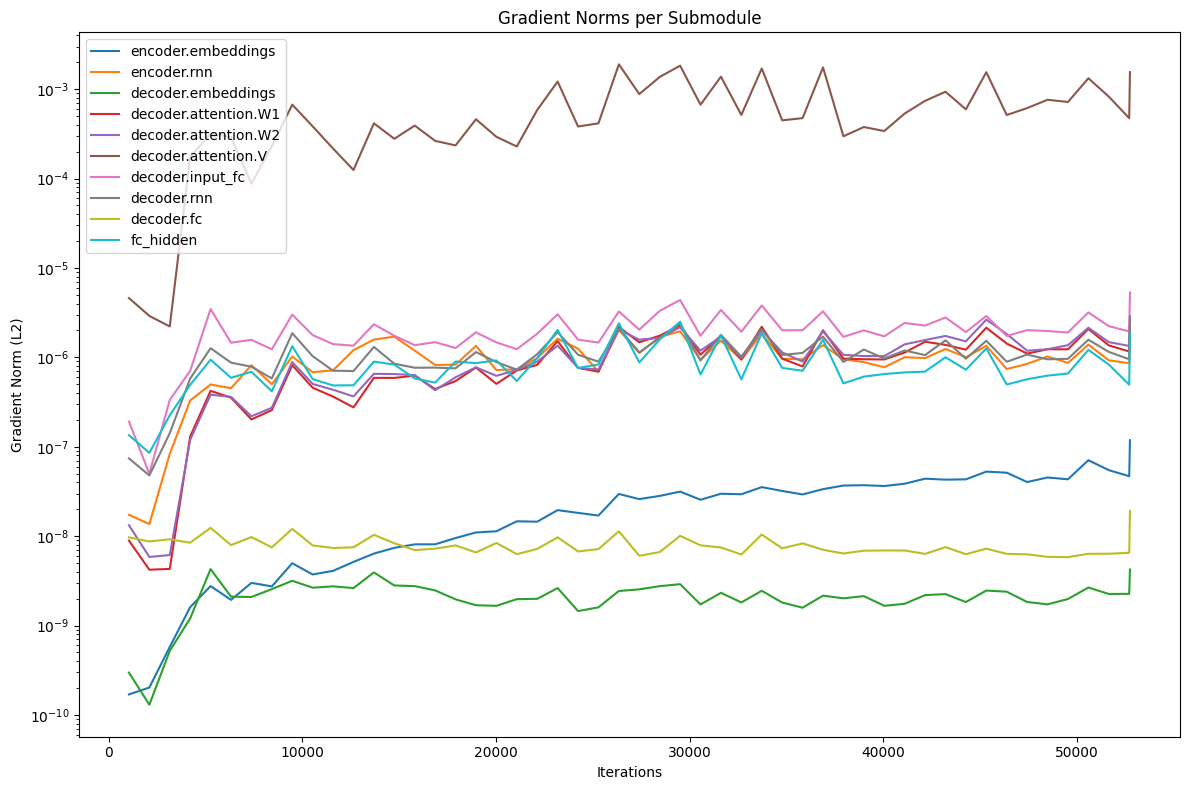

In [24]:
plt.figure(figsize=(12, 8))

for name, norms in submodule_gradients.items():
    if norms:
        plt.plot(reference_iter, norms, label=name)

plt.xlabel("Iterations")
plt.ylabel("Gradient Norm (L2)")
plt.title("Gradient Norms per Submodule")
plt.legend()

# Set the y-axis to logarithmic scale
plt.yscale('log')

plt.tight_layout()
plt.show()


Large gradient norms could indicate that the learning rate is too high, causing the model to take very large steps each optimization step.

If the gradients are close to zero, the model might be stuck in a (local) minima. The learning rate may be too low.

If the gradients gradually reduce during training, the model is converging as the weights are being fine-tuned with smaller updates.

Sudden spikes are not ideal.

In [ ]:
# torch.save(model.state_dict(), '../models/RNN-Attention_24-10-2024.pt')

In [ ]:
# import os.path

# if os.path.isfile('../models/RNN-Attention_24-10-2024.pt'):
#     print('Found saved state dictionary!')
#     model.load_state_dict(torch.load('../models/RNN-Attention_24-10-2024.pt'))

In [25]:
import nltk
from nltk.tokenize import wordpunct_tokenize

# Download the tokenizer models from nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def tokenize_sentence(sentence: str) -> list:
    """Tokenize a single sentence."""
    return ['<SOS>'] + wordpunct_tokenize(sentence) + ['<EOS>']


[nltk_data] Downloading package punkt to /home/ocmkieboom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ocmkieboom/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [26]:
import re

def translate(sentence, max_output_length=20):
	input_tokens = tokenize_sentence(sentence)
	input_indices = [eng_vocab.token_to_index_func(token) for token in input_tokens]

	output_indices, _ = model.evaluate(input_indices, device, max_output_length)
	output_tokens = [nld_vocab.index_to_token_func(index) for index in output_indices]

	new_sentence = ' '.join(output_tokens).capitalize()
	new_sentence = re.sub(r'\s+([.,!?])', r'\1', new_sentence)

	return new_sentence

In [27]:
### Use model ###

print(translate('Go!'))
print(translate('It\'s not Fine.'))
print(translate('I\'m very happy today.'))
print(translate('He\'s very sad.'))
print(translate('That man is wearing a white shirt.'))
print(translate('He\'s very afraid of spiders.'))
print(translate('He\'s going home to his wife.'))
print(translate('Those guys are walking to work.'))
print(translate('I\'m not going with you today.'))
print(translate('My girlfriend will not come over tomorrow.'))
print(translate('He bought his friends a present for christmas.'))


<sos> ik! ook ook <unk>!!!! <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> het <unk> <unk> niet niet niet niet,.. <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> ik <unk> <unk> nu heel gelukkig vandaag vandaag vandaag. <eos> <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> hij <unk> <unk> heel heel <unk>, <unk> <unk> <unk>. <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> dat man man een een een een een een <unk>.. <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> hij <unk> <unk> heel bang van voor van,.. <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> hij <unk> <unk> thuis naar zijn zijn vrouw vrouw vrouw. <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> die jongens gaan naar om werk werken werk.. <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> ik <unk> <unk> niet niet niet met vandaag vandaag vandaag.. <eos> <unk> <unk> <unk> <unk> <unk> <unk>
<sos> mijn vriendin zal niet over morgen morgen komen komen... <unk> <unk> <unk>

In [28]:
import matplotlib.pyplot as plt

def evaluateAndShowAttention():

    # Sample a random sentence from the test data
    input_indices = random.choice(test_dataset)[0]
    input_tokens = [eng_vocab.index_to_token_func(index) for index in input_indices.tolist()]

    output_indices, attentions = model.evaluate(input_indices, device)
    output_indices = output_indices[1:] # Remove single batch dimension
    output_tokens = [nld_vocab.index_to_token_func(index) for index in output_indices]

    output_tokens.insert(0, "<SOS>")

    attentions = attentions.cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='plasma')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))

    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens)

    plt.show()

/home/ocmkieboom/Projecten/vscode_notebooks/src/RNN/Seq2Seq.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(ixs, device=device).unsqueeze(0) # tensor: [1, seq_len]


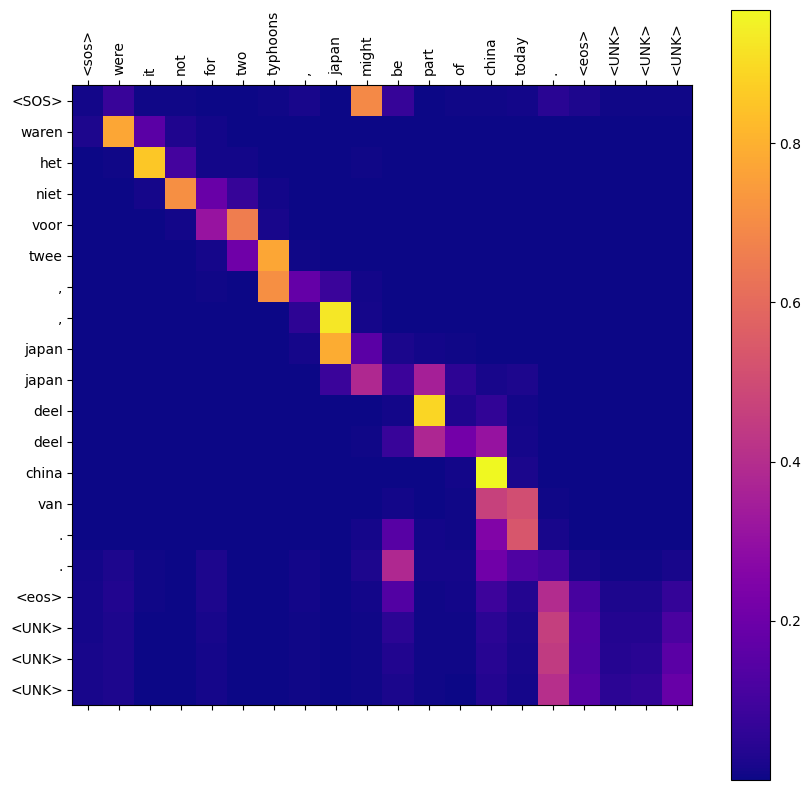

In [44]:
evaluateAndShowAttention()